<div class="alert alert-block alert-info">
    <center><h1> Benchmarking - BCIC datasets </h1></center>
</div>

# Sections

- **[1. Baseline methods](#1.-Baseline-methods)**
    - [Common Spatial Pattern](#CSP-pipeline)
    - [Filter Bank CSP](#FBCSP-pipeline)
    - [Riemannian Covariance Features](#Riemannian-pipeline)
- **[2. Deep learning methods](#2.-Deep-learning-methods)**

In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import time
import sys
sys.path.append('..')

from data_loading_functions.data_loader import EEGDataset, cropping
from sklearn.metrics import accuracy_score, cohen_kappa_score
from sklearn.pipeline import Pipeline

from visualization_functions.metric_visualizers import plot_full_barchart, plot_cm
from visualization_functions.metric_visualizers import compute_online_metrics, plot_online_metrics

# 1. Baseline methods
## CSP pipeline
[Back to top](#Sections) <br>


**BCIC IV 2a:** <br>
- **Parameters:** [2.5-4.5]s + C=0.8 + m=2
- **Mean training score:** 0.779 (accuracy) - 0.705 (kappa) <br>
- **Mean test score:** 0.671+-0.162 (accuracy) - 0.562+-0.216 (kappa) <br>
- **Mean training time per pilot/trial:** 63.4ms / 0.2ms <br>
- **Mean testing time per pilot/trial:** 41.7ms / 0.1ms <br>

**BCIC IV 2b:** <br>
- **Parameters:** [3.5-5.5]s + C=0.8 + m=1
- **Mean training score:** 0.700 (accuracy) - 0.399 (kappa) <br>
- **Mean test score:** 0.732+-0.127 (accuracy) - 0.464+-0.254 (kappa) <br>
- **Mean training time per pilot/trial:** 9.2ms / 0.0ms <br>
- **Mean testing time per pilot/trial:** 6.4ms / 0.0ms <br>

In [2]:
from preprocessing_functions.preproc_functions import filtering
from feature_extraction_functions.csp import CSP
from sklearn.svm import SVC

In [3]:
path = '../../Datasets/BCI_IV_2a/formatted_raw/'
#path = '../../Datasets/BCI_IV_2b/formatted_raw/'

train_score = { 'accuracy' : [], 'kappa' : [] }
test_score = { 'accuracy' : [], 'kappa' : [] }
conf_matrices = {}
total_train_time = 0
total_test_time = 0
n_pilots = 9

# Parameters
fs = 250
start=2.5
end=4.5
allow_cropping = False
n_crops = 1
crop_len = 2.
online_stride = fs//10
C = 0.8

for pilot_idx in range(1, n_pilots + 1):
    # Load dataset (full trial and extracted MI ROI)
    X_full_train, y_train, _, _, X_full_test, y_test = EEGDataset(pilot_idx, data_path=path, load_test=True).load_dataset()

    # Pre-processing - filtering
    X_full_train = filtering(X_full_train, fs, f_order=5, f_low=7, f_high=35, f_type='cheby')
    X_full_test = filtering(X_full_test, fs, f_order=5, f_low=7, f_high=35, f_type='cheby')
    
    # Filtering (for CSP only)
    X_train = X_full_train[:, :, int(start*fs): int(end*fs)]
    X_test = X_full_test[:, :, int(start*fs): int(end*fs)]
    
    # Cropping
    if allow_cropping:
        X_train, y_train, trial2crops_train = cropping(X_train, y_train, fs, n_crops,
                                                       crop_len, shuffled=False)
        X_test, y_test, trial2crops_test = cropping(X_test, y_test, fs, n_crops,
                                                    crop_len, shuffled=False)
    
    # Define pipeline (feature extraction and classifier)
    n_classes = len(np.unique(y_train))
    feature_extractor = CSP(n_classes=n_classes, m=2, regularize_cov=False)
    classifier = SVC(C=C, gamma='scale')
    model = Pipeline(steps=[('feat', feature_extractor), ('clf', classifier)])

    # Fit model
    train_time = time.time()
    model.fit(X=X_train, y=y_train)
    train_time = time.time() - train_time
    total_train_time += train_time
    print('Took {:.1f}ms to fit the model (about {:.1f}ms per trial).'.format(1e3*train_time, 
                                                                              1e3*train_time/X_train.shape[0]))
    
    # Validation
    y_pred = model.predict(X_train)
    train_score['accuracy'].append(accuracy_score(y_train, y_pred))
    train_score['kappa'].append(cohen_kappa_score(y_train, y_pred))

    
    test_time = time.time()
    y_pred = model.predict(X_test)
    test_time = time.time() - test_time
    total_test_time += test_time
    print('Took {:.1f}ms to perform inference (about {:.1f}ms per trial).'.format(1e3*test_time, 
                                                                                  1e3*test_time/X_test.shape[0]))
    
    # Logging for current pilot
    test_score['accuracy'].append(accuracy_score(y_test, y_pred))
    test_score['kappa'].append(cohen_kappa_score(y_test, y_pred))
    
    # Saving true/predicted labels for confusion matrix visualization
    conf_matrices['y_pred{}'.format(pilot_idx)] = y_pred
    conf_matrices['y_true{}'.format(pilot_idx)] = y_test
    
    # Logging for current pilot
    print('Pilot {} - Train: {:.3f}/{:.3f} - Test: {:.3f}/{:.3f}. \n'.format(pilot_idx,
                                                                         train_score['accuracy'][-1],
                                                                         train_score['kappa'][-1],
                                                                         test_score['accuracy'][-1],
                                                                         test_score['kappa'][-1]))

print('Mean training score: {:.3f} (accuracy) - {:.3f} (kappa)'.format(np.mean(train_score['accuracy']),
                                                                       np.mean(train_score['kappa'])))
print('Mean test score: {:.3f}+-{:.3f} (accuracy) - {:.3f}+-{:.3f} (kappa)'.format(np.mean(test_score['accuracy']),
                                                                                  np.std(test_score['accuracy']),
                                                                                  np.mean(test_score['kappa']),
                                                                                  np.std(test_score['kappa'])))
print('Mean training time per pilot/trial: {:.1f}ms / {:.1f}ms'.format(1e3*total_train_time/n_pilots,
                                                                  1e3*total_train_time/(n_pilots*X_train.shape[0])))
print('Mean testing time per pilot/trial: {:.1f}ms / {:.1f}ms'.format(1e3*total_test_time/n_pilots,
                                                                  1e3*total_test_time/(n_pilots*X_train.shape[0])))

Properties: 288 train trials - 22 channels - 7.5s trial length
Selecting classes [0, 1, 2, 3] & balancing...
Selecting 22 channels
Selecting time-window [0.0 - 7.5]s - (7.5s)...
Output shapes:  (288, 22, 1875) (288, 22, 1875) (288, 22, 1875)
Output classes:  [0 1 2 3]
Took 119.8ms to fit the model (about 0.4ms per trial).
Took 52.9ms to perform inference (about 0.2ms per trial).
Pilot 1 - Train: 0.861/0.815 - Test: 0.747/0.662. 

Properties: 288 train trials - 22 channels - 7.5s trial length
Selecting classes [0, 1, 2, 3] & balancing...
Selecting 22 channels
Selecting time-window [0.0 - 7.5]s - (7.5s)...
Output shapes:  (288, 22, 1875) (288, 22, 1875) (288, 22, 1875)
Output classes:  [0 1 2 3]
Took 93.8ms to fit the model (about 0.3ms per trial).
Took 83.7ms to perform inference (about 0.3ms per trial).
Pilot 2 - Train: 0.653/0.537 - Test: 0.486/0.315. 

Properties: 288 train trials - 22 channels - 7.5s trial length
Selecting classes [0, 1, 2, 3] & balancing...
Selecting 22 channels
Se

<IPython.core.display.Javascript object>


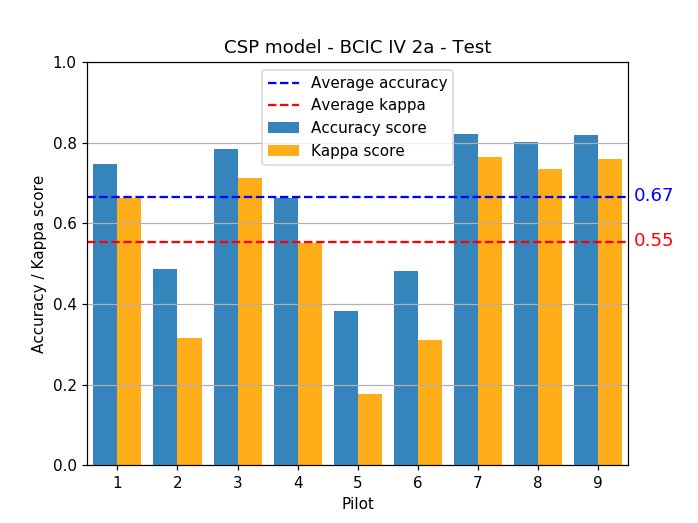

<IPython.core.display.Javascript object>


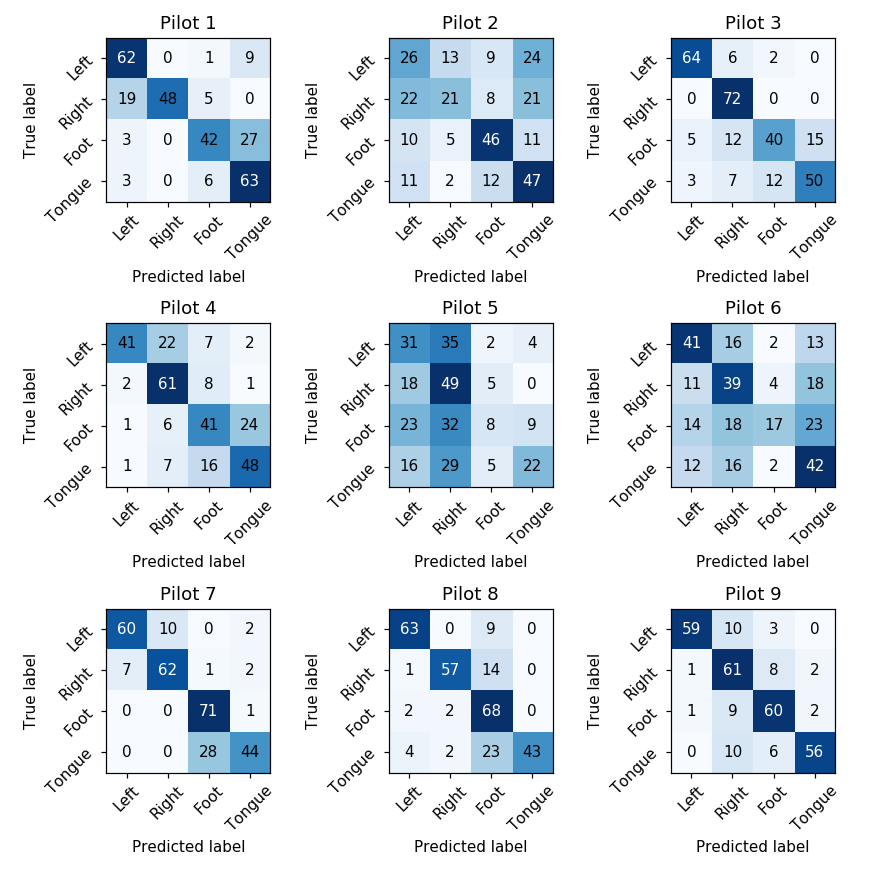

In [15]:
%matplotlib notebook

plot_full_barchart(test_score, n_pilots=n_pilots, title='CSP model - BCIC IV 2a - Test')

fig, ax = plt.subplots(3, 3, figsize=(8,8))
[ plot_cm(conf_matrices, p+1, fig=fig, ax_idx=p, title='Pilot {}'.format(p+1)) for p in range(9)]
fig.tight_layout()

<IPython.core.display.Javascript object>


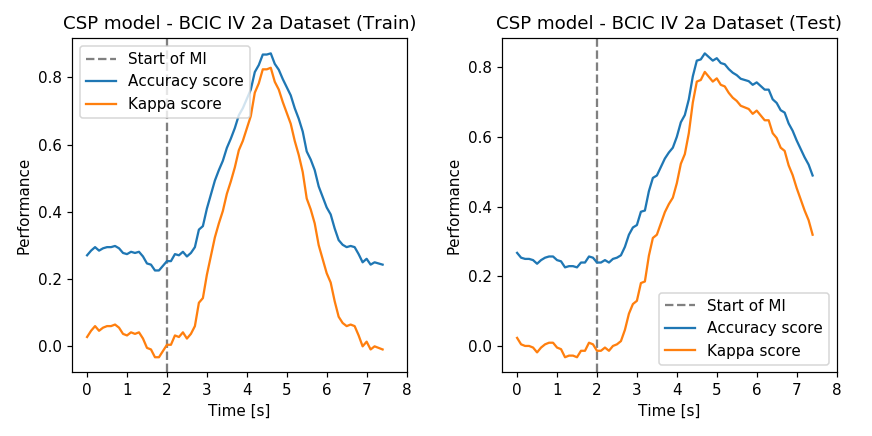

In [23]:
# What would be the online performance ?
online_stride = fs//10
crop_samples = int(crop_len * fs)

fig, ax = plt.subplots(1,2, figsize=(8,4))

scores_online, _ = compute_online_metrics(model, X_full_train, y_train, crop_samples, online_stride)
plot_online_metrics(scores_online, len_tot=X_full_train.shape[-1], n_folds=1, stride=online_stride, 
                    title='CSP model - BCIC IV 2a Dataset (Train)', fig=fig, ax_idx=0);

scores_online, _ = compute_online_metrics(model, X_full_test, y_test, crop_samples, online_stride)
plot_online_metrics(scores_online, len_tot=X_full_test.shape[-1], n_folds=1, stride=online_stride, 
                    title='CSP model - BCIC IV 2a Dataset (Test)', fig=fig, ax_idx=1);
fig.tight_layout()

## FBCSP pipeline
[Back to top](#Sections) <br>

**BCIC IV 2a:**
- **Parameters:** [2.5-4.5]s + FBCSP(m=2, k=-1) + SVM(C=20, rbf)
- **Mean training score:** 0.995 (accuracy) - 0.994 (kappa) <br>
- **Mean test score:** 0.675+-0.160 (accuracy) - 0.566+-0.213 (kappa) <br>
- **Mean training time per pilot/trial:** 2.4s / 8.5ms <br>
- **Mean testing time per pilot/trial:** 1.1s / 4.0ms <br>

**BCIC IV 2b:** <br>
- **Parameters:** [3.5-5.5]s + FBCSP(m=1, k=-1) + SVM(C=20, rbf)
- **Mean training score:** 0.768 (accuracy) - 0.536 (kappa) <br>
- **Mean test score:** 0.777+-0.136 (accuracy) - 0.553+-0.272 (kappa) <br>
- **Mean training time per pilot/trial:** 0.3s / 0.7ms <br>
- **Mean testing time per pilot/trial:** 0.1s / 0.2ms

In [30]:
from feature_extraction_functions.fbcsp import FBCSP
from sklearn.svm import SVC

In [31]:
# Choose dataset
dataset = 'BCI IV 2a' # {'BCI IV 2a', 'BCI IV 2b'}

# Choose parameters (tunable)
start = 2.5
end = 4.5
rereferencing, standardization, clip = False, False, False
m = 2 # CSP pairs
f_type, f_order = 'butter', 2 # FBCSP filter bank parameters
k = -1 # No feature selection
C = 20

# Dataset parameters (don't modify unless data_path is different)
fs = 250
n_pilots = 9
data_path = '../../Datasets/{}/formatted_raw/'.format('BCI_IV_2a' if dataset=='BCI IV 2a' else 'BCI_IV_2b')

dataloader_params = {
        'data_path' : data_path,
        'fs' : fs,
        'start' : start,
        'end' : end,
        'rereferencing' : rereferencing,
        'standardization' : standardization,
        'valid_ratio' : 0.0,
        'load_test' : True}

train_score = { 'accuracy' : [], 'kappa' : [] }
test_score = { 'accuracy' : [], 'kappa' : [] }
conf_matrices = {}
total_train_time = 0
total_test_time = 0

n_pilots = 9
for pilot_idx in range(1, n_pilots + 1):
    # Load dataset
    X_train, y_train, X_valid, y_valid, X_test, y_test = EEGDataset(pilot_idx, **dataloader_params).load_dataset()
    
    # Define pipeline (feature extraction and classifier)
    feature_extractor = FBCSP(fs, len(np.unique(y_train)), m, f_order, f_type, k)
    classifier = SVC(C, kernel='rbf', gamma='auto')
    model = Pipeline(steps=[('feat', feature_extractor), ('clf', classifier)])

    # Fit model
    train_time = time.time()
    model.fit(X=X_train, y=y_train)
    train_time = time.time() - train_time
    total_train_time += train_time
    print('Took {:.1f}s to fit the model (about {:.1f}ms per trial).'.format(train_time, 
                                                                             1e3*train_time/X_train.shape[0]))
    
    # Validation
    y_pred = model.predict(X_train)
    train_score['accuracy'].append(accuracy_score(y_train, y_pred))
    train_score['kappa'].append(cohen_kappa_score(y_train, y_pred))

    
    test_time = time.time()
    y_pred = model.predict(X_test)
    test_time = time.time() - test_time
    total_test_time += test_time
    print('Took {:.1f}s to perform inference (about {:.1f}ms per trial).'.format(test_time, 
                                                                                 1e3*test_time/X_test.shape[0]))
    
    # Logging for current pilot
    test_score['accuracy'].append(accuracy_score(y_test, y_pred))
    test_score['kappa'].append(cohen_kappa_score(y_test, y_pred))
    
    # Saving true/predicted labels for confusion matrix visualization
    conf_matrices['y_pred{}'.format(pilot_idx)] = y_pred
    conf_matrices['y_true{}'.format(pilot_idx)] = y_test
    
    # Logging for current pilot
    print('Pilot {} - Train: {:.3f}/{:.3f} - Test: {:.3f}/{:.3f}. \n'.format(pilot_idx,
                                                                         train_score['accuracy'][-1],
                                                                         train_score['kappa'][-1],
                                                                         test_score['accuracy'][-1],
                                                                         test_score['kappa'][-1]))

print('Mean training score: {:.3f} (accuracy) - {:.3f} (kappa)'.format(np.mean(train_score['accuracy']),
                                                                       np.mean(train_score['kappa'])))
print('Mean test score: {:.3f}+-{:.3f} (accuracy) - {:.3f}+-{:.3f} (kappa)'.format(np.mean(test_score['accuracy']),
                                                                                  np.std(test_score['accuracy']),
                                                                                  np.mean(test_score['kappa']),
                                                                                  np.std(test_score['kappa'])))
print('Mean training time per pilot/trial: {:.1f}s / {:.1f}ms'.format(total_train_time/n_pilots,
                                                                      1e3*total_train_time/(n_pilots*X_train.shape[0])))
print('Mean testing time per pilot/trial: {:.1f}s / {:.1f}ms'.format(total_test_time/n_pilots,
                                                                     1e3*total_test_time/(n_pilots*X_train.shape[0])))

Properties: 288 train trials - 22 channels - 7.5s trial length
Selecting classes [0, 1, 2, 3] & balancing...
Selecting 22 channels
Selecting time-window [2.5 - 4.5]s - (2.0s)...
Output shapes:  (288, 22, 500) (288, 22, 500) (288, 22, 500)
Output classes:  [0 1 2 3]
Took 2.0s to fit the model (about 6.8ms per trial).
Took 0.8s to perform inference (about 2.8ms per trial).
Pilot 1 - Train: 1.000/1.000 - Test: 0.760/0.681. 

Properties: 288 train trials - 22 channels - 7.5s trial length
Selecting classes [0, 1, 2, 3] & balancing...
Selecting 22 channels
Selecting time-window [2.5 - 4.5]s - (2.0s)...
Output shapes:  (288, 22, 500) (288, 22, 500) (288, 22, 500)
Output classes:  [0 1 2 3]
Took 1.9s to fit the model (about 6.7ms per trial).
Took 0.9s to perform inference (about 3.0ms per trial).
Pilot 2 - Train: 0.993/0.991 - Test: 0.472/0.296. 

Properties: 288 train trials - 22 channels - 7.5s trial length
Selecting classes [0, 1, 2, 3] & balancing...
Selecting 22 channels
Selecting time-wi

<IPython.core.display.Javascript object>


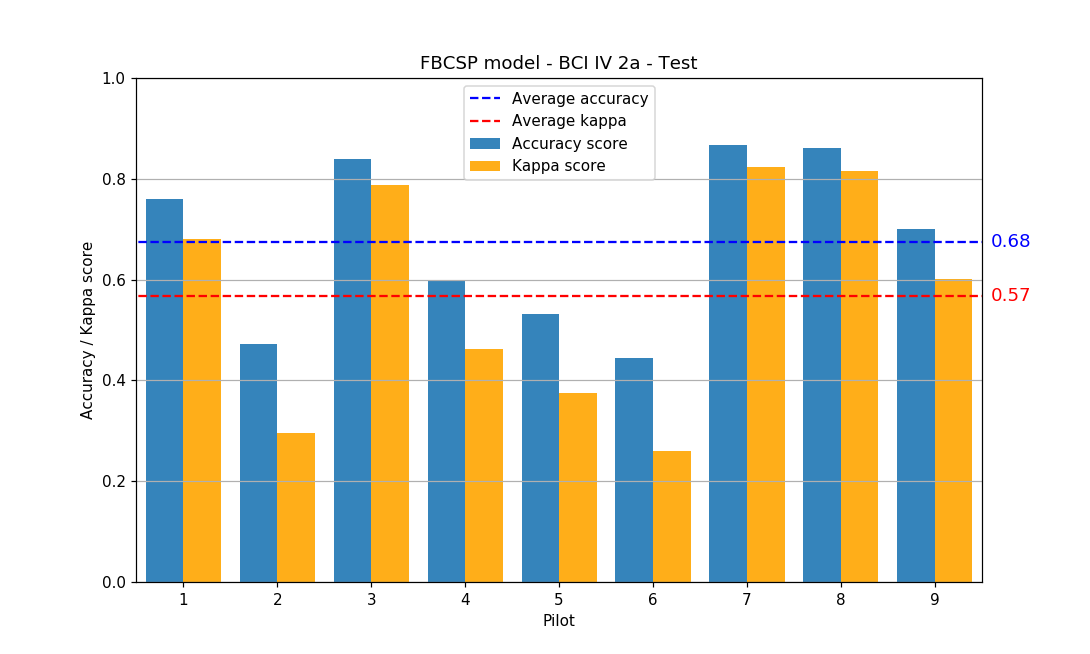

<IPython.core.display.Javascript object>


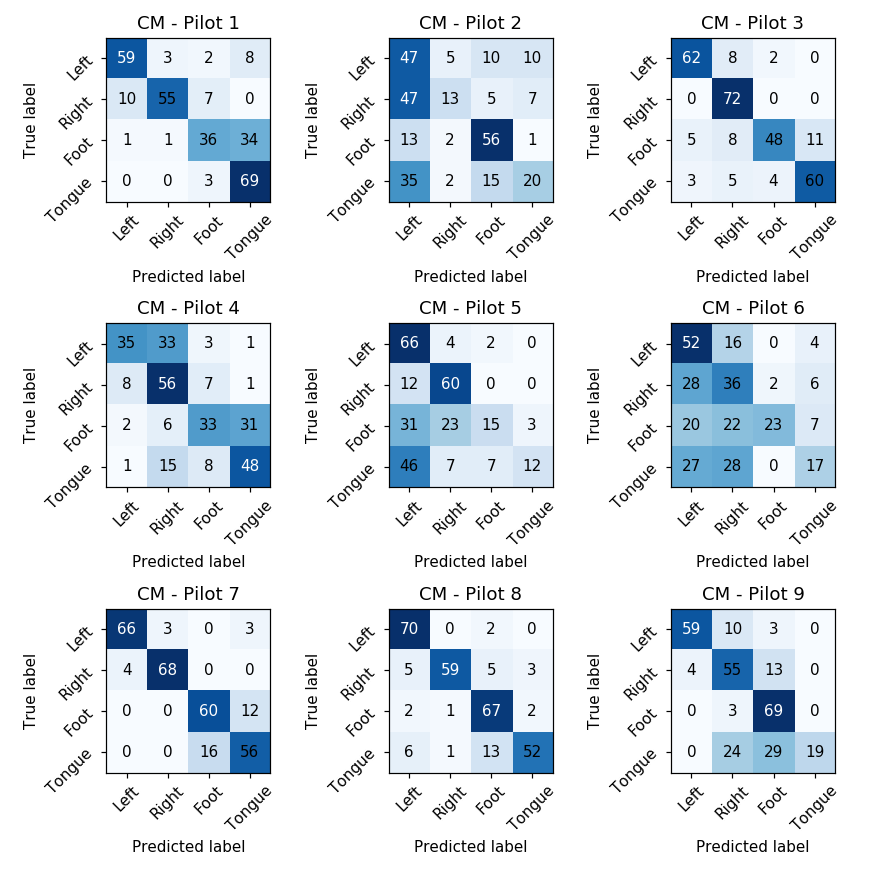

In [32]:
%matplotlib notebook

# Results visualization

# Test accuracy/kappa scores barchart
fig, ax = plt.subplots(figsize=(10,6))
plot_full_barchart(test_score, n_pilots=n_pilots, title='FBCSP model - {} - Test'.format(dataset), fig=fig);

# Confusion matrices
fig, ax = plt.subplots(3, 3, figsize=(8,8))
[ plot_cm(conf_matrices, p+1, fig=fig, ax_idx=p, title='CM - Pilot {}'.format(p+1)) for p in range(9)]
fig.tight_layout()

Properties: 288 train trials - 22 channels - 7.5s trial length
Selecting classes [0, 1, 2, 3] & balancing...
Selecting 22 channels
Selecting time-window [0.0 - 7.5]s - (7.5s)...
Output shapes:  (288, 22, 1875) (288, 22, 1875) (288, 22, 1875)
Output classes:  [0 1 2 3]


<IPython.core.display.Javascript object>


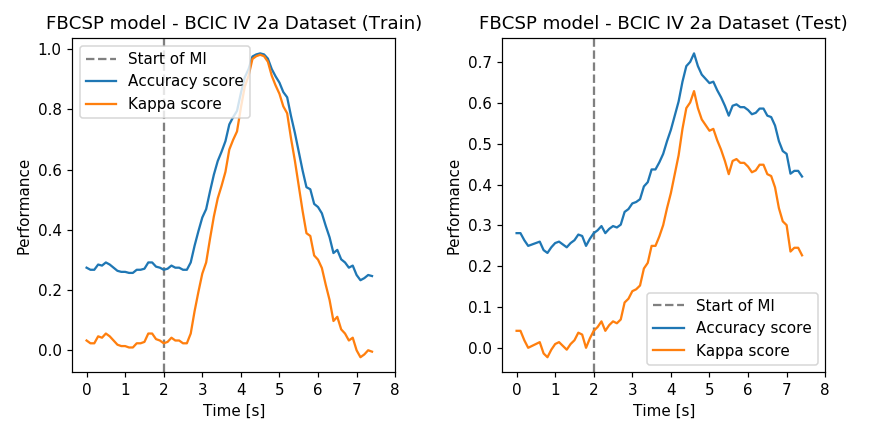

In [33]:
# What would be the online performance ?
online_stride = fs//10
crop_len = end - start
crop_samples = int(crop_len * fs)

# Load dataset (full trial and extracted MI ROI)
X_full_train, y_train, _, _, X_full_test, y_test = EEGDataset(9, data_path=data_path, 
                                                              load_test=True).load_dataset()

fig, ax = plt.subplots(1,2, figsize=(8,4))

scores_online, _ = compute_online_metrics(model, X_full_train, y_train, crop_samples, online_stride)
plot_online_metrics(scores_online, len_tot=X_full_train.shape[-1], n_folds=1, stride=online_stride, 
                    title='FBCSP model - BCIC IV 2a Dataset (Train)', fig=fig, ax_idx=0);

scores_online, _ = compute_online_metrics(model, X_full_test, y_test, crop_samples, online_stride)
plot_online_metrics(scores_online, len_tot=X_full_test.shape[-1], n_folds=1, stride=online_stride, 
                    title='FBCSP model - BCIC IV 2a Dataset (Test)', fig=fig, ax_idx=1);
fig.tight_layout()

<IPython.core.display.Javascript object>


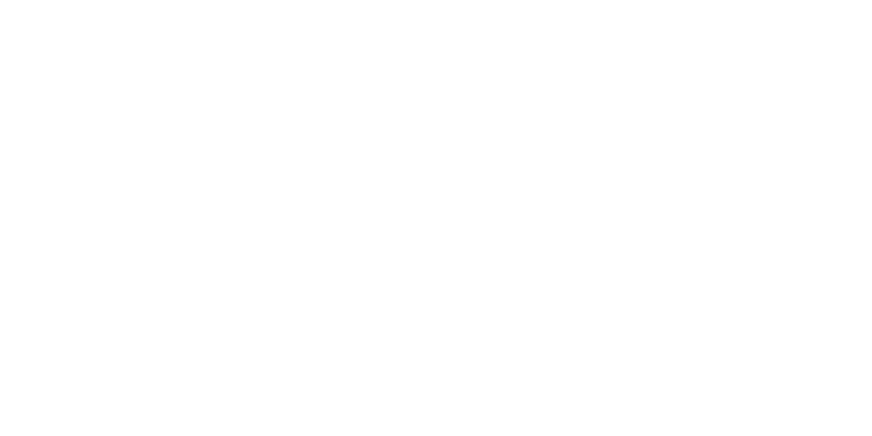

Properties: 400 train trials - 3 channels - 7.5s trial length
Selecting classes [0, 1] & balancing...
Selecting 3 channels
Selecting time-window [0.0 - 7.5]s - (7.5s)...
Output shapes:  (400, 3, 1875) (400, 3, 1875) (320, 3, 1875)
Output classes:  [0 1]


NameError: name 'y_full_train' is not defined

In [10]:
online_stride = fs//10
crop_len = end - start
crop_samples = int(crop_len * fs)

fig, ax = plt.subplots(1,2, figsize=(8,4))

# Load dataset (full trial and extracted MI ROI)
X_full_train, y_train, _, _, X_full_test, y_test = EEGDataset(1, data_path=data_path, 
                                                              load_test=True).load_dataset()

scores_online = compute_online_metrics(model, X_full_train, y_full_train, crop_samples, online_stride)
plot_online_metrics(scores_online, len_tot=X_full_train.shape[-1], n_folds=1, stride=online_stride, 
                    title='FBCSP model - {} (Train)'.format(dataset), fig=fig, ax_idx=0);

scores_online = compute_online_metrics(model, X_full_test, y_full_test, crop_samples, online_stride)
plot_online_metrics(scores_online, len_tot=X_full_test.shape[-1], n_folds=1, stride=online_stride, 
                    title='FBCSP model - {} (Test)'.format(dataset), fig=fig, ax_idx=1);
fig.tight_layout()

## Riemannian pipeline
[Back to top](#Sections) <br>


**BCIC IV 2a:**
- **Parameters:** [2.5, 6] + Riemann(n_classes=4) + LinearSVC(C=0.1) <br>
- **Mean training score:** 1.000 (accuracy) - 1.000 (kappa) <br>
- **Mean test score:** 0.752+-0.144 (accuracy) - 0.669+-0.192 (kappa) <br>
- **Mean training time per pilot/trial:** 17.3s / 59.9ms <br>
- **Mean testing time per pilot/trial:** 11.0s / 38.1ms 


**BCIC IV 2b:**
- **Parameters:** [3.5, 6] + Riemann(n_classes=2) + LinearSVC(C=0.01)
- **Mean training score:** 0.824 (accuracy) - 0.648 (kappa) 
- **Mean test score:** 0.793+-0.133 (accuracy) - 0.585+-0.266 (kappa) 
- **Mean training time per pilot/trial:** 2.5s / 6.2ms 
- **Mean testing time per pilot/trial:** 1.6s / 3.9ms

In [20]:
from feature_extraction_functions.riemann import Riemann
from sklearn.svm import LinearSVC

In [21]:
# Choose dataset
dataset = 'BCI IV 2b' # {'BCI IV 2a', 'BCI IV 2b'}

# Choose parameters (tunable)
start = 3.5 
end = 7.
filt, rereferencing, standardization = False, False, False
f_type, f_order = 'butter', 2 # Riemann filter bank parameters 
C = 0.01

# Dataset parameters (don't modify unless data_path is different)
fs = 250
n_pilots = 9
data_path = '../../Datasets/{}/formatted_raw/'.format('BCI_IV_2a' if dataset=='BCI IV 2a' else 'BCI_IV_2b')

dataloader_params = {
        'data_path' : data_path,
        'fs' : fs,
        'start' : start,
        'end' : end,
        'rereferencing' : rereferencing,
        'standardization' : standardization,
        'valid_ratio' : 0.0,
        'load_test' : True}

train_score = { 'accuracy' : [], 'kappa' : [] }
test_score = { 'accuracy' : [], 'kappa' : [] }
conf_matrices = {}
total_train_time = 0
total_test_time = 0
n_pilots = 9

for pilot_idx in range(1, n_pilots + 1):
    # Load dataset
    X_train, y_train, X_valid, y_valid, X_test, y_test = EEGDataset(pilot_idx, **dataloader_params).load_dataset()

    # Define pipeline (feature extraction and classifier)
    feature_extractor = Riemann(fs, len(np.unique(y_train)), f_order, f_type)
    classifier = LinearSVC(C=C)
    model = Pipeline(steps=[('feat', feature_extractor), ('clf', classifier)])
    
    # Fit model
    train_time = time.time()
    model.fit(X=X_train, y=y_train)
    train_time = time.time() - train_time
    total_train_time += train_time
    print('Took {:.1f}s to fit the model (about {:.1f}ms per trial).'.format(train_time, 
                                                                               1e3*train_time/X_train.shape[0]))
    
    # Validation
    y_pred = model.predict(X_train)
    train_score['accuracy'].append(accuracy_score(y_train, y_pred))
    train_score['kappa'].append(cohen_kappa_score(y_train, y_pred))
    
    test_time = time.time()
    y_pred = model.predict(X_test)
    test_time = time.time() - test_time
    total_test_time += test_time
    print('Took {:.1f}s to perform inference (about {:.1f}ms per trial).'.format(test_time,
                                                                                   1e3*test_time/X_test.shape[0]))
    
    # Logging for current pilot
    test_score['accuracy'].append(accuracy_score(y_test, y_pred))
    test_score['kappa'].append(cohen_kappa_score(y_test, y_pred))
    
    # Saving true/predicted labels for confusion matrix visualization
    conf_matrices['y_pred{}'.format(pilot_idx)] = y_pred
    conf_matrices['y_true{}'.format(pilot_idx)] = y_test
    
    # Logging for current pilot
    print('Pilot {} - Train: {:.3f}/{:.3f} - Test: {:.3f}/{:.3f}.\n'.format(pilot_idx,
                                                                             train_score['accuracy'][-1],
                                                                             train_score['kappa'][-1],
                                                                             test_score['accuracy'][-1],
                                                                             test_score['kappa'][-1]))
    
print('Mean training score: {:.3f} (accuracy) - {:.3f} (kappa)'.format(np.mean(train_score['accuracy']),
                                                                       np.mean(train_score['kappa'])))
print('Mean test score: {:.3f}+-{:.3f} (accuracy) - {:.3f}+-{:.3f} (kappa)'.format(np.mean(test_score['accuracy']),
                                                                                   np.std(test_score['accuracy']),
                                                                                   np.mean(test_score['kappa']),
                                                                                   np.std(test_score['kappa'])))
print('Mean training time per pilot/trial: {:.1f}s / {:.1f}ms'.format(total_train_time/n_pilots,
                                                                1e3*total_train_time/(n_pilots*X_train.shape[0])))
print('Mean testing time per pilot/trial: {:.1f}s / {:.1f}ms'.format(total_test_time/n_pilots,
                                                                1e3*total_test_time/(n_pilots*X_train.shape[0])))

Properties: 400 train trials - 3 channels - 7.5s trial length
Selecting classes [0, 1] & balancing...
Selecting 3 channels
Selecting time-window [3.5 - 7.0]s - (3.5s)...
Output shapes:  (400, 3, 875) (400, 3, 875) (320, 3, 875)
Output classes:  [0 1]
Took 2.5s to fit the model (about 6.3ms per trial).
Took 1.5s to perform inference (about 4.7ms per trial).
Pilot 1 - Train: 0.922/0.845 - Test: 0.787/0.575.

Properties: 400 train trials - 3 channels - 7.5s trial length
Selecting classes [0, 1] & balancing...
Selecting 3 channels
Selecting time-window [3.5 - 7.0]s - (3.5s)...
Output shapes:  (400, 3, 875) (400, 3, 875) (280, 3, 875)
Output classes:  [0 1]
Took 2.4s to fit the model (about 6.0ms per trial).
Took 1.3s to perform inference (about 4.7ms per trial).
Pilot 2 - Train: 0.748/0.495 - Test: 0.532/0.064.

Properties: 400 train trials - 3 channels - 7.5s trial length
Selecting classes [0, 1] & balancing...
Selecting 3 channels
Selecting time-window [3.5 - 7.0]s - (3.5s)...
Output sha

<IPython.core.display.Javascript object>


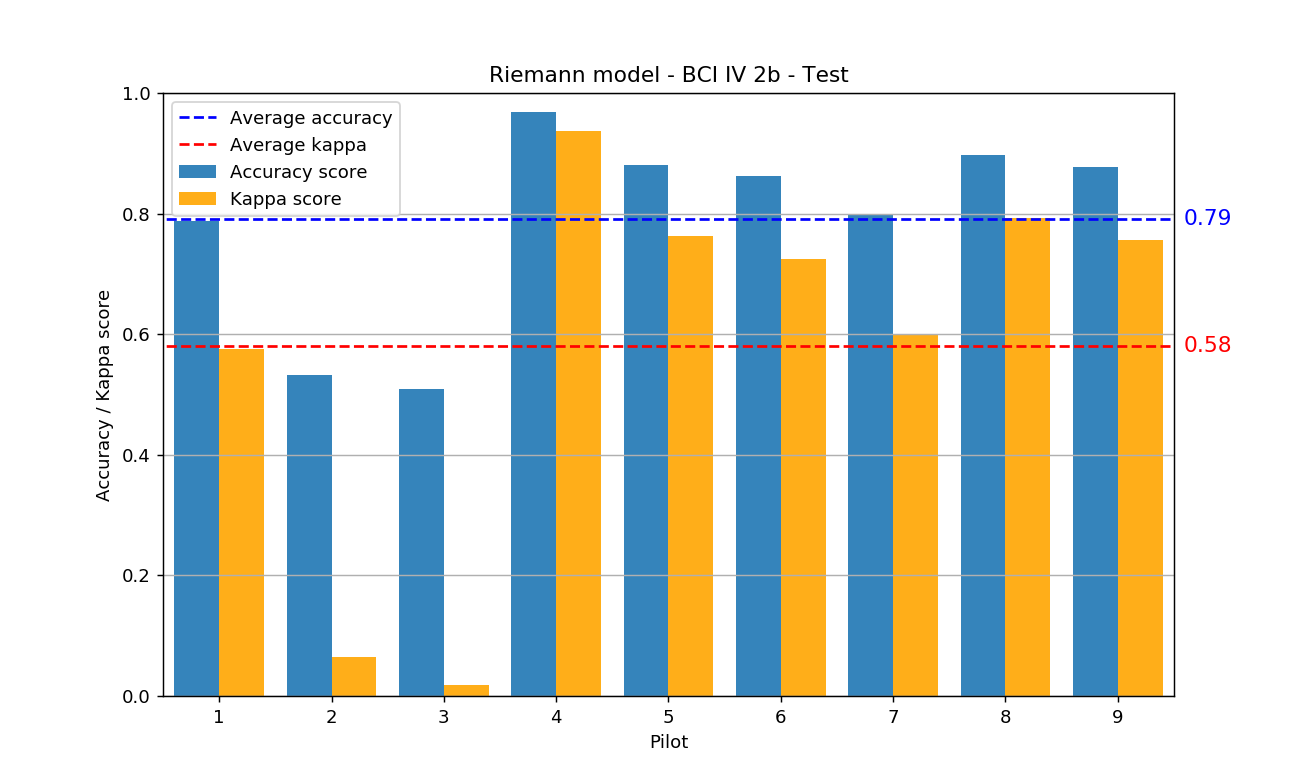

<IPython.core.display.Javascript object>


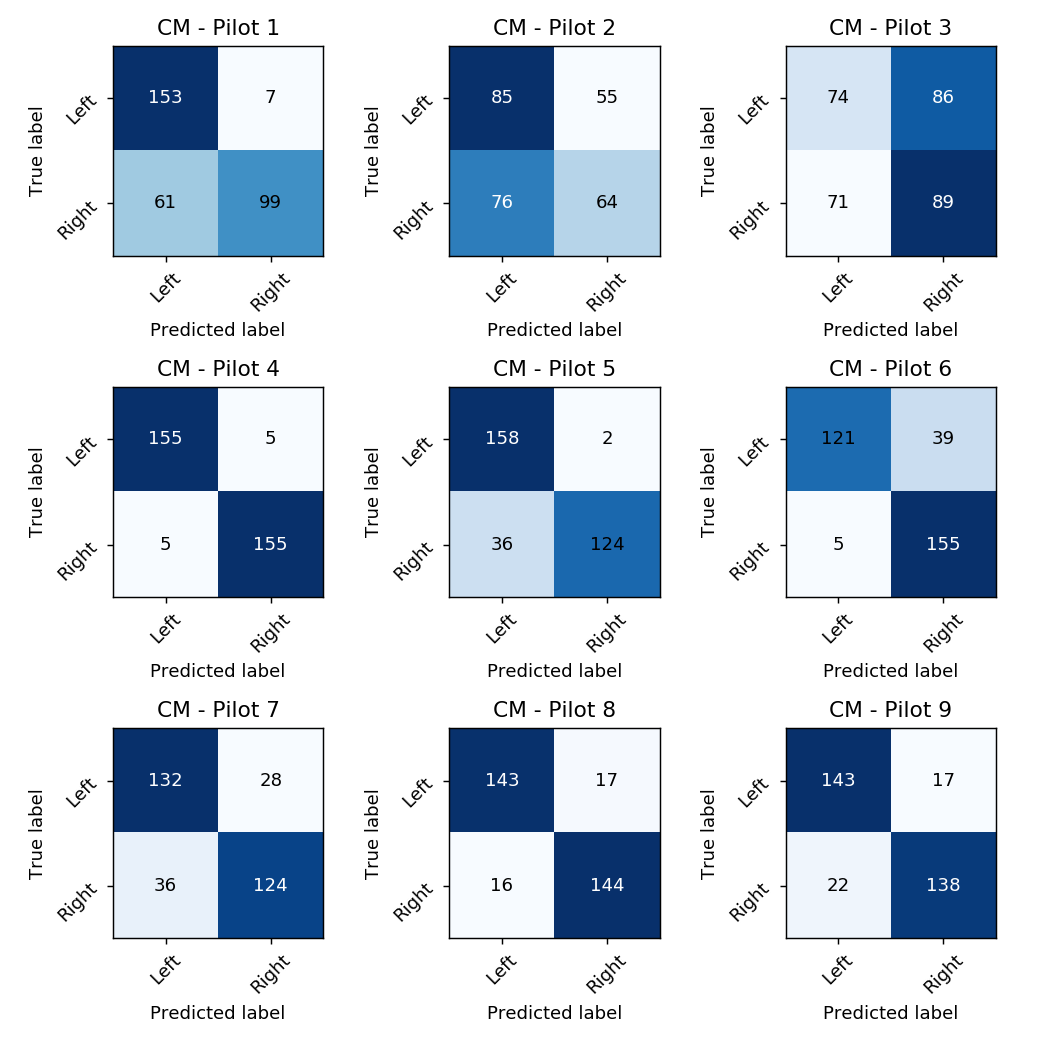

In [23]:
%matplotlib notebook

# Test accuracy/kappa scores barchart
fig, ax = plt.subplots(figsize=(10,6))
plot_full_barchart(test_score, n_pilots=n_pilots, title='Riemann model - {} - Test'.format(dataset), fig=fig);

# Confusion matrices
fig, ax = plt.subplots(3, 3, figsize=(8,8))
[ plot_cm(conf_matrices, p+1, fig=fig, ax_idx=p, title='CM - Pilot {}'.format(p+1)) for p in range(9)]
fig.tight_layout()

# 2. Deep learning methods
## Shallow ConvNet pipeline
[Back to top](#Sections) <br>

<font color='red'><h2> Train on GPU ! </h2></font>

**Colab:** https://colab.research.google.com/drive/1cRHG0g0a_X-yfjg7U_QXlCQ4idBmjHNm

In [18]:
import keras
import keras.backend as K
K.set_image_data_format("channels_first")

from keras.callbacks import Callback, ModelCheckpoint, EarlyStopping
from keras.utils import to_categorical
from sklearn.utils import shuffle 
from feature_extraction_functions.convnets import ShallowConvNet

In [19]:
# Choose dataset and model
dataset = 'BCI IV 2b' # {'BCI IV 2a', 'BCI IV 2b'}
model_name = 'Shallow' # {'Shallow', 'Deep', 'EEGNet'}
 
# Choose parameters (tunable)
patience = 50
batch_size = 64
start = 2.75
end = 5.
filt, rereferencing, standardization = True, True, True
f_order, f_low, f_high = 3, 0, 38
valid_ratio = 0.2
pretraining = True

# Dataset parameters (don't modify unless data_path is different)
fs = 250
n_pilots = 9
data_path = '../../Datasets/{}/formatted_raw/'.format('BCI_IV_2a' if dataset=='BCI IV 2a' else 'BCI_IV_2b')

dataloader_params = {
        'data_path' : data_path,
        'fs' : fs,
        'start' : start,
        'end' : end,
        'filt' : filt,
        'f_order' : f_order, 
        'f_low' : f_low, 
        'f_high' : f_high,
        'rereferencing' : rereferencing,
        'standardization' : standardization,
        'valid_ratio' : valid_ratio,
        'load_test' : True}

train_score = { 'accuracy' : [], 'kappa' : [] }
test_score = { 'accuracy' : [], 'kappa' : [] }
conf_matrices = {}
total_train_time = 0
total_test_time = 0

# Pretraining
if pretraining:
    X_train, y_train, X_valid, y_valid, X_test, y_test = [], [], [], [], [], []        
    for pilot_idx in range(1, n_pilots + 1):
        X_train_pilot, y_train_pilot, X_valid_pilot, y_valid_pilot, X_test_pilot, y_test_pilot = EEGDataset(pilot_idx, 
                                                                                                            **dataloader_params).load_dataset()
        
        # Stacking training/validation datasets of each pilot into a big dataset
        if len(X_train)==0 and len(X_valid)==0:
            X_train = X_train_pilot
            y_train = y_train_pilot
            X_valid = X_valid_pilot
            y_valid = y_valid_pilot
            X_test = X_test_pilot
            y_test = y_test_pilot
        else:        
            X_train = np.concatenate([X_train, X_train_pilot], axis=0)
            y_train = np.concatenate([y_train, y_train_pilot], axis=0)
            X_valid = np.concatenate([X_valid, X_valid_pilot], axis=0)
            y_valid = np.concatenate([y_valid, y_valid_pilot], axis=0)
            X_test = np.concatenate([X_test, X_test_pilot], axis=0)
            y_test = np.concatenate([y_test, y_test_pilot], axis=0)
            
    # Shuffle
    X_train, y_train = shuffle(X_train, y_train, random_state=0)
    X_valid, y_valid = shuffle(X_valid, y_valid, random_state=0)
    X_test, y_test = shuffle(X_test, y_test, random_state=0)

    # Reshape in Keras format (n_trials, n_filter, n_channels, n_samples)
    n_trials, n_channels, n_samples = X_train.shape
    X_train = np.reshape(X_train, (n_trials, 1, n_channels, n_samples))
    print(X_train.shape)

    n_trials, n_channels, n_samples = X_valid.shape
    X_valid = np.reshape(X_valid, (n_trials, 1, n_channels, n_samples))
    print(X_valid.shape)

    n_trials, n_channels, n_samples = X_test.shape
    X_test = np.reshape(X_test, (n_trials, 1, n_channels, n_samples))
    print(X_test.shape)

    n_classes = len(np.unique(y_train))

    # Build model
    model = ShallowConvNet(nb_classes=n_classes, n_channels=n_channels, n_samples=n_samples)

    # Train on all pilots
    es = EarlyStopping(patience=patience, monitor='val_loss', verbose=1)
    mc = ModelCheckpoint('pretrained_model.h5', 'val_loss', verbose=0, save_best_only=True, save_weights_only=True)
    loss = 'binary_crossentropy' if n_classes==2 else 'categorical_crossentropy'
    model.compile(loss=loss, optimizer=keras.optimizers.Adam(), metrics=['accuracy'])

    # Train model & get metrics evolution w.r.t epochs
    pretrain_time = time.time()
    hist = model.fit(x=X_train, y=to_categorical(y_train), batch_size=batch_size, epochs=500, 
                     shuffle=True, verbose=0, validation_data=(X_valid, to_categorical(y_valid)), 
                     callbacks=[es, mc])
    pretrain_time = time.time() - pretrain_time
    print('Took {:.1f}s to fit the model on all pilots.\n'.format(pretrain_time))

    # Load best pretrained model
    model.load_weights('pretrained_model.h5')

    # Validation
    y_pred_train = np.argmax(model.predict(X_train), axis=1)
    y_pred_test = np.argmax(model.predict(X_test), axis=1)
    print('All pilots - Train: {:.3f}/{:.3f} - Test: {:.3f}/{:.3f} \n'.format(accuracy_score(y_train, y_pred_train),
                                                                          cohen_kappa_score(y_train, y_pred_train),
                                                                          accuracy_score(y_test, y_pred_test),
                                                                          cohen_kappa_score(y_test, y_pred_test)))

for pilot_idx in range(1, n_pilots + 1):
    X_train, y_train, X_valid, y_valid, X_test, y_test = EEGDataset(pilot_idx, **dataloader_params).load_dataset()

    # Reshape in Keras format (n_trials, n_filter, n_channels, n_samples)
    n_trials, n_channels, n_samples = X_train.shape
    X_train = np.reshape(X_train, (n_trials, 1, n_channels, n_samples))
    print(X_train.shape)

    n_trials, n_channels, n_samples = X_valid.shape
    X_valid = np.reshape(X_valid, (n_trials, 1, n_channels, n_samples))
    print(X_valid.shape)
    
    n_trials, n_channels, n_samples = X_test.shape
    X_test = np.reshape(X_test, (n_trials, 1, n_channels, n_samples))
    print(X_test.shape)

    n_classes = len(np.unique(y_train))

    # Load architecture (using pretraining)
    model = ShallowConvNet(nb_classes=n_classes, n_channels=n_channels, n_samples=n_samples)
    if pretraining:
        model.load_weights('pretrained_model.h5')

    # Training parameters
    es = EarlyStopping(patience=patience, monitor='val_loss', verbose=1)
    mc = ModelCheckpoint('best_model.h5', 'val_loss', verbose=0, save_best_only=True, save_weights_only=True)
    loss = 'binary_crossentropy' if n_classes==2 else 'categorical_crossentropy'
    model.compile(loss=loss, optimizer=keras.optimizers.Adam(), metrics=['accuracy'])

    # Train model & get metrics evolution w.r.t epochs
    print('Fitting model...')
    train_time = time.time()
    hist = model.fit(x=X_train, y=to_categorical(y_train), batch_size=batch_size, epochs=500, 
                     shuffle=True, verbose=0, 
                     validation_data=(X_valid, to_categorical(y_valid)), callbacks=[es, mc])
    train_time = time.time() - train_time
    total_train_time += train_time
    print('Took {:.1f}s to fit the model (about {:.1f}ms per trial).\n'.format(train_time, 
                                                                               1e3*train_time/X_train.shape[0]))
    
    

    best_epoch = np.argmin(hist.history['val_loss'])
    print('Best epoch: {} - Valid loss: {:.2} - Valid acc: {:.2}'.format(best_epoch, 
                                                                         hist.history['val_loss'][best_epoch],
                                                                         hist.history['val_acc'][best_epoch]))

    # Load best model
    model.load_weights('best_model.h5')

    # Validation
    y_pred = np.argmax(model.predict(X_train), axis=1)
    train_score['accuracy'].append(accuracy_score(y_train, y_pred))
    train_score['kappa'].append(cohen_kappa_score(y_train, y_pred))

    test_time = time.time()
    y_pred = np.argmax(model.predict(X_test), axis=1)
    test_time = time.time() - test_time
    test_score['accuracy'].append(accuracy_score(y_test, y_pred))
    test_score['kappa'].append(cohen_kappa_score(y_test, y_pred))
    total_test_time += test_time
    print('Took {:.1f}s to perform inference (about {:.1f}ms per trial).\n'.format(test_time, 
                                                                                   1e3*test_time/X_test.shape[0]))

    # Logging for current pilot
    print('Pilot {} - Train: {:.3f}/{:.3f} - Test: {:.3f}/{:.3f} \n'.format(pilot_idx,
                                                                            train_score['accuracy'][-1],
                                                                            train_score['kappa'][-1],
                                                                            test_score['accuracy'][-1],
                                                                            test_score['kappa'][-1]))

    # Saving true/predicted labels for confusion matrix visualization
    conf_matrices['y_pred{}'.format(pilot_idx)] = y_pred
    conf_matrices['y_true{}'.format(pilot_idx)] = y_test

print('Mean training score: {:.3f} (accuracy) - {:.3f} (kappa)'.format(np.mean(train_score['accuracy']),
                                                                       np.mean(train_score['kappa'])))
print('Mean test score: {:.3f}+-{:.3f} (accuracy) - {:.3f}+-{:.3f} (kappa)'.format(np.mean(test_score['accuracy']),
                                                                                   np.std(test_score['accuracy']),
                                                                                   np.mean(test_score['kappa']),
                                                                                   np.std(test_score['kappa'])))

print('Pretraining time: ', pretrain_time)
print('Mean training time per pilot/trial: {:.1f}s / {:.1f}ms'.format(total_train_time/n_pilots,
                                                              1e3*total_train_time/(n_pilots*X_train.shape[0])))
print('Mean testing time per pilot/trial: {:.1f}ms / {:.1f}ms'.format(1e3*total_test_time/n_pilots,
                                                              1e3*total_test_time/(n_pilots*X_train.shape[0])))

Properties: 400 train trials - 3 channels - 7.5s trial length
Selecting classes [0, 1] & balancing...
Selecting 3 channels
Selecting time-window [2.748 - 5.0]s - (2.252s)...
Filtering (0-38)Hz...
Standardizing...
Re-referencing...
Output shapes:  (320, 3, 563) (80, 3, 563) (320, 3, 563)
Output classes:  [0 1]
Properties: 400 train trials - 3 channels - 7.5s trial length
Selecting classes [0, 1] & balancing...
Selecting 3 channels
Selecting time-window [2.748 - 5.0]s - (2.252s)...
Filtering (0-38)Hz...
Standardizing...
Re-referencing...
Output shapes:  (320, 3, 563) (80, 3, 563) (280, 3, 563)
Output classes:  [0 1]
Properties: 400 train trials - 3 channels - 7.5s trial length
Selecting classes [0, 1] & balancing...
Selecting 3 channels
Selecting time-window [2.748 - 5.0]s - (2.252s)...
Filtering (0-38)Hz...
Standardizing...
Re-referencing...
Output shapes:  (320, 3, 563) (80, 3, 563) (320, 3, 563)
Output classes:  [0 1]
Properties: 420 train trials - 3 channels - 7.5s trial length
Selec

KeyboardInterrupt: 

<IPython.core.display.Javascript object>


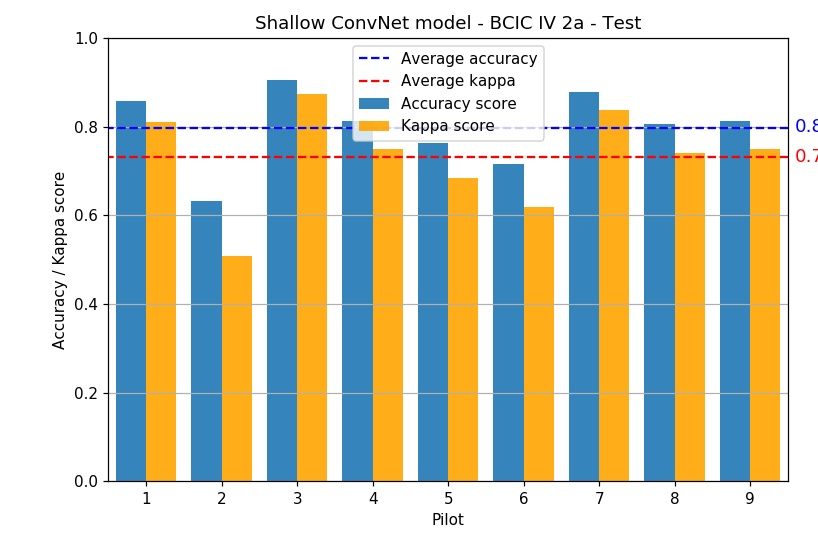

In [19]:
%matplotlib notebook

# Test accuracy/kappa scores barchart
fig, ax = plt.subplots(figsize=(10,6))
plot_full_barchart(test_score, n_pilots=n_pilots, 
                   title=' {} - {} ConvNet model - Test'.format(dataset, model_name), fig=fig);

# Confusion matrices
fig, ax = plt.subplots(3, 3, figsize=(10,10))
[ plot_cm(conf_matrices, p+1, fig=fig, ax_idx=p, title='CM - Pilot {}'.format(p+1)) for p in range(9)]
fig.tight_layout()